## Clasificador de Noticias Argentinas 

In [160]:
import pandas as pd

df = pd.read_excel('../../res/tp1/Noticias_argentinas.xlsx', sheet_name='aa_bayes')

In [161]:
# Nos quedamos con los atributos de interes

df = df[["titular", "categoria"]]

# removemos las categorias que no necesitamos ('Destacadas', 'Noticias Destacadas')


df.head()

,titular,categoria
0,Trabajadores del Buenos Aires Design cortan la...,Nacional
1,La boda del gobernador Gerardo Morales: tapas ...,Nacional
2,Cumbre del G20: qué calles estarán cortadas y ...,Nacional
3,Una fractura que confirma la candidatura de Cr...,Nacional
4,Infierno grande: ola de divorcios en un pueblo...,Nacional


In [162]:
df = df.loc[df['categoria'].isin(("Nacional", "Economia", "Internacional", "Deportes", "Salud", "Ciencia y Tecnologia", "Entretenimiento"))]
df.head()
categories = df['categoria'].unique()
print(categories)


['Nacional' 'Deportes' 'Salud' 'Ciencia y Tecnologia' 'Entretenimiento'
 'Economia' 'Internacional']


In [163]:
df['categoria'].value_counts()

Nacional                3860
Ciencia y Tecnologia    3856
Deportes                3855
Economia                3850
Internacional           3850
Entretenimiento         3850
Salud                   3840
Name: categoria, dtype: int64

In [164]:
from sklearn.model_selection import train_test_split

# Separar los datos en datos de entrenamiento y testeo
train, test = train_test_split(df, test_size=0.2)
train.head()
test.head()

,titular,categoria
21327,Los casos de sarampión aumentaron un 30% en to...,Salud
25893,"Los cerebros más grandes son más inteligentes,...",Ciencia y Tecnologia
2366,Vacunación refuerzo de la triple viral,Salud
14541,No falla: este es el truco para recuperar tus ...,Ciencia y Tecnologia
5006,Campaña de detección gratuita de artritis psor...,Salud


In [165]:
textos = list(df['titular'])

In [166]:
# Crear diccionario de categorias con diccionarios vacios para las palabras de los titulares
categories_word_appearances = { i : {} for i in categories }

In [167]:
import re

def split_and_sanitize(title):
    words = title.split()  # se separan las palabras según espacios (quita todos los espacios)
    words = list(map(lambda x: re.sub("[^\w\s]", '', x), words))  # reemplazo de símbolos por ningún caracter
    return words

for i in range(len(train)):
    row = train.iloc[i]
    category = row['categoria']
    title = row['titular']
    words = split_and_sanitize(title)
    
    for word in words:
            if word in categories_word_appearances[category]:
                categories_word_appearances[category][word] += 1
            else:
                categories_word_appearances[category][word] = 1
                
    
    
    

In [168]:
print(categories_word_appearances['Entretenimiento']['Pampita'])

65


In [169]:
# Calcular probabilidades de las clases P(category) para el conjunto de entrenamiento

category_relative_freq = train['categoria'].value_counts() / len(train)  # P(category)
print(category_relative_freq)

# Calcular las probabilidades condicionales P(word | category)
word_relative_frequencies = { i : {} for i in categories }
zero_probabilities = { i : 0 for i in categories } # Laplace correction in case a word does not appear in a category
for category in categories:
    word_appearances_sum = sum(categories_word_appearances[category].values())
    laplace_denominator = float(word_appearances_sum + len(categories_word_appearances[category].keys()))
    zero_probabilities[category] = 1 / laplace_denominator
    for word, word_count in categories_word_appearances[category].items():
        word_relative_frequencies[category][word] = (word_count + 1) / laplace_denominator

print(word_relative_frequencies['Entretenimiento']['Pampita'])
print(sum(word_relative_frequencies['Entretenimiento'].values()))
# Objetivo final:
#   P (category | [word])
# = P ([word] | category) * P (category)      ##  / P ([word])
# = prod(P (word | category)) * P (category)

Economia                0.143731
Internacional           0.143268
Ciencia y Tecnologia    0.143268
Deportes                0.142851
Entretenimiento         0.142572
Salud                   0.142248
Nacional                0.142062
Name: categoria, dtype: float64
0.0014123689278835866
1.0000000000000244


In [170]:
def classify(title):
    words = split_and_sanitize(title)
    vs = {}
    for category in categories:
        v = category_relative_freq.loc[category]
        for word in words:
            if word in word_relative_frequencies[category]:
                v *= word_relative_frequencies[category][word]
            else:
                v *= zero_probabilities[category]
        vs[category] = v
        print(v)
    mx = (None, 0)
    for category, v in vs.items():
        if v > mx[1]:
            mx = (category, v)
    return mx[0]

noticia = 'Pampita fue a la mesa de Mirtha'
print(f"La noticia '{noticia}' pertenece a {classify(noticia)}")
noticia = 'Messi metió un gol'
print(f"La noticia '{noticia}' pertenece a {classify(noticia)}")
noticia = 'Apple lanzó un nuevo iPhone'
print(f"La noticia '{noticia}' pertenece a {classify(noticia)}")

3.940813839811322e-22
2.6855293884880296e-22
1.4068880360954685e-22
2.726210214383248e-23
1.798207415492222e-17
2.4567614040249586e-23
6.341208225633148e-22
La noticia 'Pampita fue a la mesa de Mirtha' pertenece a Entretenimiento
1.40285115783844e-16
4.2196133996362605e-13
3.278834570124502e-17
2.5396687236962863e-17
7.136218686211331e-16
1.5305841672233124e-16
1.0322106120693551e-16
La noticia 'Messi metió un gol' pertenece a Deportes
2.171740297867855e-20
2.5240569448529522e-20
7.872771958253215e-20
1.8831660676845406e-14
1.1029179794177817e-19
1.6457793436163814e-18
9.05641956748147e-19
La noticia 'Apple lanzó un nuevo iPhone' pertenece a Ciencia y Tecnologia


2.387021322568352e-42
4.896664926810233e-43
1.9541548581975656e-33
1.1558161720566212e-43
1.3110368992795904e-42
2.004410459297928e-40
3.022162854760687e-41
8.722442012743907e-39
1.0699348645757838e-37
9.800421426320978e-35
4.085551679344092e-34
1.2532953605184095e-38
2.2302712532320666e-35
1.8508997934653913e-38
1.957948216061503e-21
9.97871516404414e-21
8.541562985137036e-17
5.351583062844792e-22
8.003639405253946e-22
8.022864532199633e-23
2.7486238940979527e-22
4.407550051259503e-47
4.129591853263336e-47
1.1562998891719131e-46
2.487750951453165e-37
3.4083015980142325e-47
8.200760360145178e-47
3.0309355926931125e-46
3.8879748989803614e-35
6.415093986732782e-35
1.3317954920697716e-25
7.564174301895212e-35
2.62183122561685e-35
1.0515838053822404e-34
3.4737807106810764e-35
2.0733536188030628e-63
1.6832062751937258e-62
8.048276658322083e-66
2.194978531295427e-48
6.014531986148328e-65
1.1520797773225067e-56
3.974175553868546e-61
1.397288063435541e-48
2.899696600536522e-50
6.21502789984732

<AxesSubplot:>

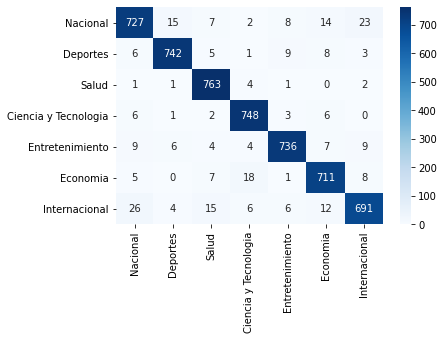

In [171]:
confusion_matrix = { i : {} for i in categories }
columns = []
for key in confusion_matrix.keys():
    columns.append(key)
    confusion_matrix[key] = { i : 0 for i in categories } # {'Deportes': {'Deportes': 700, 'Entretenimiento': 3, ...}, ...}

for i in range(len(test)):
    row = test.iloc[i]
    category = row['categoria']
    title = row['titular']
    result = classify(title)
    confusion_matrix[category][result] += 1

confusion_df = { key : list(confusion_matrix[key].values()) for key in confusion_matrix.keys() }
confusion_df = pd.DataFrame.from_dict(confusion_df, orient='index', columns=columns)

import seaborn as sns
sns.heatmap(confusion_df, annot=True, cmap='Blues', fmt='g')

In [172]:
import numpy as np

true = []
predicted = []

for i in range(len(test)):
    row = test.iloc[i]
    true.append(row['categoria'])
    title = row['titular']
    predicted.append(classify(title))

    
# Calculamos las metricas para cada categoria    
    
category_metrics = { i : {'tp': 0, 'tn': 0, 'fp': 0, 'fn': 0, 'accuracy': 0, 'precision': 0, 'recall': 0,  'f1': 0} for i in categories }

for i, category in enumerate(categories):
    
    # Metricas simples
    tp = confusion_df.iloc[i,i]
    tn = sum(np.diag(confusion_df)) - tp
    fn = sum(confusion_df.loc[category]) - tp
    fp = sum(confusion_df[category]) - tp
    
    category_metrics[category]['tp'] = tp
    category_metrics[category]['tn'] = tn
    category_metrics[category]['fp'] = fp
    category_metrics[category]['fn'] = fn
    
    # Metricas compuestas
    category_metrics[category]['accuracy'] = (tp + tn) / (tp + tn + fn + fp)
    category_metrics[category]['precision'] = tp / (tp + fp)
    category_metrics[category]['recall'] = tp / (tp + fn)
    category_metrics[category]['f1'] = (2 * category_metrics[category]['precision'] * category_metrics[category]['recall']) / (category_metrics[category]['precision'] + category_metrics[category]['recall'])

metric_cols = ['tp', 'tn', 'fp', 'fn', 'accuracy', 'precision', 'recall', 'f1']
metrics_df = { key : list(category_metrics[key].values()) for key in category_metrics.keys() }    
metrics_df = pd.DataFrame.from_dict(category_metrics, orient='index', columns=metric_cols)
metrics_df.head()

# Calculamos las metricas para el classifier en general (checkear cual es la forma correcta)
    
tp, fp, fn = 0, 0, 0


for i, category in enumerate(categories):
    tp += confusion_df.iloc[i, i]
    fp += sum(confusion_df.iloc[i, :i])
    fn += sum(confusion_df.iloc[i, i+1:])
    
tn = confusion_df.to_numpy().sum() - (fp + fn + tp)

accuracy = (tp + tn) / (tp + tn + fn + fp)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = (2 * precision * recall) / (precision + recall)

metrics_df

    



2.387021322568352e-42
4.896664926810233e-43
1.9541548581975656e-33
1.1558161720566212e-43
1.3110368992795904e-42
2.004410459297928e-40
3.022162854760687e-41
8.722442012743907e-39
1.0699348645757838e-37
9.800421426320978e-35
4.085551679344092e-34
1.2532953605184095e-38
2.2302712532320666e-35
1.8508997934653913e-38
1.957948216061503e-21
9.97871516404414e-21
8.541562985137036e-17
5.351583062844792e-22
8.003639405253946e-22
8.022864532199633e-23
2.7486238940979527e-22
4.407550051259503e-47
4.129591853263336e-47
1.1562998891719131e-46
2.487750951453165e-37
3.4083015980142325e-47
8.200760360145178e-47
3.0309355926931125e-46
3.8879748989803614e-35
6.415093986732782e-35
1.3317954920697716e-25
7.564174301895212e-35
2.62183122561685e-35
1.0515838053822404e-34
3.4737807106810764e-35
2.0733536188030628e-63
1.6832062751937258e-62
8.048276658322083e-66
2.194978531295427e-48
6.014531986148328e-65
1.1520797773225067e-56
3.974175553868546e-61
1.397288063435541e-48
2.899696600536522e-50
6.21502789984732

,tp,tn,fp,fn,accuracy,precision,recall,f1
Nacional,727,4391,53,69,0.976718,0.932051,0.913317,0.922589
Deportes,742,4376,27,32,0.988603,0.964889,0.958656,0.961763
Salud,763,4355,40,9,0.990517,0.950187,0.988342,0.968889
Ciencia y Tecnologia,748,4370,35,18,0.989751,0.955300,0.976501,0.965784
Entretenimiento,736,4382,28,39,0.987078,0.963351,0.949677,0.956465
Economia,711,4407,47,39,0.983474,0.937995,0.948000,0.942971
Internacional,691,4427,45,69,0.978211,0.938859,0.909211,0.923797


In [173]:
# Calcular cantidad total de apariciones de palabras
totalCount = 0
uniqueWords = set({})
for category in categories:
    for key in categories_word_appearances[category].keys():
        totalCount += categories_word_appearances[category][key]
        uniqueWords.add(key)
        
print(totalCount)
print(len(uniqueWords))

273808
14312


In [174]:
# Calcular curva ROC
            
def calc_word_prob(word): # P(word)
    wordCount = 0
    
    for category in categories:
        if word in categories_word_appearances[category]:
            wordCount += categories_word_appearances[category][word]
            
    # print(f"wordCount / float(totalCount): {wordCount / float(totalCount)}")  
    return (wordCount + 1) / float(totalCount + len(uniqueWords))
    
    

def classify_with_prob(title):
    words = split_and_sanitize(title)
    
    vs = {}
    for category in categories:
        v = category_relative_freq.loc[category]
        
        for word in words:
            # word count / total de apariciones de todas las palabras
            word_prob = calc_word_prob(word)
            
            #for c in categories:
            #    word_prob += (word_relative_frequencies[c][word] if word in word_relative_frequencies[c] else zero_probabilities[c]) * category_relative_freq.loc[c]
            
            if word in word_relative_frequencies[category]:
                v *= word_relative_frequencies[category][word] / word_prob
                #print(f"{category}: {word}: {word_relative_frequencies[category][word]} {word_relative_frequencies[category][word] / word_prob}")
            else:
                v *= zero_probabilities[category] / word_prob
                #print(f"{category}: {word}: {zero_probabilities[category]} {zero_probabilities[category] / word_prob}")
        vs[category] = v #/ word_prob
    total_prob = sum(vs.values())
    #print(vs)
    #mx = (None, 0)
    #tot = 0
    #for category, v in vs.items():
    #    if v > mx[1]:
    #        mx = (category, v)
    #    tot += v
    #print(tot)
    return vs

In [175]:
x = 0
for word in uniqueWords:
    x += calc_word_prob(word)
print(x)

1.000000000000036


In [176]:
print(classify_with_prob("Los gremios del transporte"))
print(test.iloc[1].titular)

{'Nacional': 4.307550139278756, 'Deportes': 0.003842356956729014, 'Salud': 0.0021627766040752615, 'Ciencia y Tecnologia': 0.004467401621332896, 'Entretenimiento': 0.0006166697521856221, 'Economia': 0.0075358780028064645, 'Internacional': 0.0020643918195093714}
Los cerebros más grandes son más inteligentes, pero no por mucho


In [ ]:
for index, category in enumerate(categories):
    test.insert(index + 2, f"prob_{category}", 0)

In [188]:
import matplotlib.pyplot as plt

#classification_probs = []
u = [0.1 * x for x in range(1, 10)]

category_metrics = { i : { x : {'tp': 0, 'tn': 0, 'fp': 0, 'fn': 0} for x in u} for i in categories }

for i in range(100):#len(test)):
    row = test.iloc[i]
    category = row['categoria']
    title = row['titular']
    vs = classify_with_prob(title)
    
    for cat, v in vs.items():
        test.loc[i, f"prob_{cat}"] = v

for category in categories:
    records = test.query(f"categoria == {category}")
    for index, record in records.iterrows()
        prob = record[f"prob_{category}"]
        for threshold in u:
            if prob >= threshold:
                category_metrics[category][threshold]['tp'] += 1
            else:
                category_metrics[category][threshold]['fn'] += 1
    for record in test.query(f"categoria != {category}")
        prob = record[f"prob_{category}"]
        for threshold in u:
            if prob >= threshold:
                category_metrics[category][threshold]['fp'] += 1
            else:
                category_metrics[category][threshold]['tn'] += 1
    
print(category_metrics)

SyntaxError: invalid syntax (<ipython-input-188-69124ef3d553>, line 19)